# Imports

In [1]:
from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-paper")
plt.rcParams["image.cmap"] = "Dark2"

# Setup Data

In [4]:
n_obs = 2048
n_feats = 2

In [5]:
params_blobs = dict(
    n_samples=n_obs, n_features=n_feats,
    centers=[
        [-2, -2], [2, 2],
        [-2, 2], [2, -2],
    ],
    cluster_std=1.2
)

In [6]:
params_moons = dict(
    n_samples=n_obs, noise=0.2,
)

## Blobs
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)

In [7]:
def get_blobs():
    data, target = datasets.make_blobs(**params_blobs)
    target = np.isin(target, [0, 1]) * 2 - 1
    return data, target

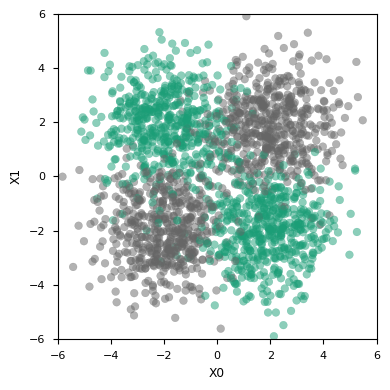

In [8]:
data, target = get_blobs()

plt.figure(figsize=(4, 4))
plt.scatter(data[:, 0], data[:, 1], c=target, alpha=.5)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel("X0")
plt.ylabel("X1")
plt.tight_layout()
plt.show()
plt.close()

## Moons
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)

In [9]:
def get_moons():
    data, target = datasets.make_moons(**params_moons)

    target = (target == 1) * 2 - 1
    data = data - [data[:, 0].mean(), data[:, 1].mean()]
    return data, target

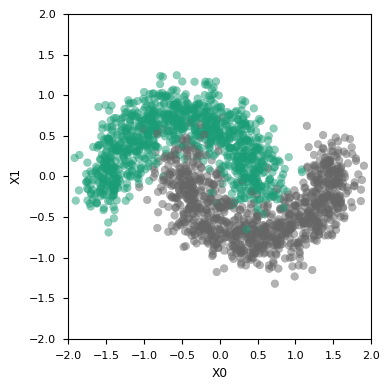

In [10]:
data, target = get_moons()

plt.figure(figsize=(4, 4))
plt.scatter(data[:, 0], data[:, 1], c=target, alpha=.5)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("X0")
plt.ylabel("X1")
plt.tight_layout()
plt.show()
plt.close()

# Modeling

In [11]:
neurons = 16

## Step by step

### Training

In [12]:
X_train, X_test, y_train, y_test = train_test_split(*get_blobs(), test_size=.3)

* Generate random hidden layer weights

In [13]:
w_input = np.random.uniform(size=(X_train.shape[1] + 1, neurons))
w_input.shape

(3, 16)

* Calculate hidden layer input

In [14]:
hidden_input = (
    np.hstack([np.ones(shape=(X_train.shape[0], 1)), X_train])
    @ w_input
)
hidden_input.shape

(1433, 16)

* Calculate hidden layer output

In [15]:
hidden_output = np.tanh(hidden_input)
hidden_output = np.hstack([
    np.ones(shape=(X_train.shape[0], 1)),
    hidden_output
])
hidden_output.shape

(1433, 17)

* Calculate output layer weights

In [16]:
w_output = np.linalg.pinv(hidden_output) @ y_train
w_output.shape

(17,)

### Testing

* Calculate hidden layer input

In [17]:
hidden_input = (
    np.hstack([np.ones(shape=(X_test.shape[0], 1)), X_test])
    @ w_input
)
hidden_input.shape

(615, 16)

* Calculate hidden layer output

In [18]:
hidden_output = np.tanh(hidden_input)
hidden_output = np.hstack([
    np.ones(shape=(X_test.shape[0], 1)),
    hidden_output
])
hidden_output.shape

(615, 17)

* Calculate output layer input values

In [19]:
output_input = hidden_output @ w_output
output_input.shape

(615,)

* Output layer activation function is linear

In [20]:
preds = (output_input.reshape(-1, 1) > 0).reshape(-1) * 2 - 1
preds.shape

(615,)

### Evaluate

In [21]:
from collections import Counter

In [22]:
print(classification_report(
    y_true=y_test, y_pred=preds,
    zero_division=0,
))

              precision    recall  f1-score   support

          -1       0.86      0.88      0.87       295
           1       0.89      0.87      0.88       320

    accuracy                           0.87       615
   macro avg       0.87      0.87      0.87       615
weighted avg       0.87      0.87      0.87       615



## Setup sklearn model class

In [23]:
class ELMClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self, neurons: int):
        self.neurons = neurons

    def fit(self, X, y):
        # generate random hidden layer weights
        self.w_input_ = np.random.uniform(size=(X.shape[1] + 1, self.neurons))

        # calculate hidden layer input
        hidden_input = (
            np.hstack([np.ones(shape=(X.shape[0], 1)), X])
            @ self.w_input_
        )

        # calculate hidden layer output
        hidden_output = np.tanh(hidden_input)
        hidden_output = np.hstack([
            np.ones(shape=(X.shape[0], 1)),
            hidden_output
        ])
        
        # calculate output layer weights
        self.w_output_ = np.linalg.pinv(hidden_output) @ y

        return self

    def predict(self, X):
        # calculate hidden layer input
        hidden_input = (
            np.hstack([np.ones(shape=(X.shape[0], 1)), X])
            @ self.w_input_
        )

        # calculate hidden layer output
        hidden_output = np.tanh(hidden_input)
        hidden_output = np.hstack([
            np.ones(shape=(X.shape[0], 1)),
            hidden_output
        ])

        # calculate output layer input values
        output_input = hidden_output @ self.w_output_

        # output layer activateion function is linear
        return output_input.reshape(-1, 1)

In [24]:
value = np.ceil(np.max([np.absolute(X_test.min()), np.absolute(X_test.max())]))
grid = np.linspace(-1 * value, value, num=256)

---